**Description:**

This script loads NA-CORDEX data, performs the Mann Kendall test for trend, and plots the result of the Theil-Sen slope estimator over the Mississippi River Basin (with statistically significant points noted with a black dot). 

**Overview of Mann-Kendall Usage:**

For a set of measured values $\{y_1,\dots,y_n\}$ (number of extreme precipitation events), the Mann-Kendall test statistic can be found by computing the sign of the difference between a measured value, $y_j$, and all earlier values $\{y_i : j > i\}$ and summing over all possible combinations, yielding
\begin{equation}
    S=\sum_{i=1}^{n-1}\sum_{j=i+1}^n\text{sgn}(y_j-y_i)
\end{equation}
$S$ can be used to calculate the test statistic $\tau$, which ranges from -1 to 1 and is analgous to the correlation coefficent in regression analysis, by
\begin{equation}
    \tau = \frac{S}{n(n-1)/2}
\end{equation}
The null hypothesis is rejected when both $S,\tau$ are far away from 0. In the code, this corresponds to `mk_results['h']=True` at a specific gridcell. Gridcells which satisfy this condition are marked with a black dot. The result of Theil-Sen's slope estimator is plotted at all points, which is caluculated by
\begin{equation}
    \beta_1 = \text{median}\left(\frac{y_j-y_i}{x_j-x_i}\right)
\end{equation}
for all $j>i$ and $i=1,\dots,n-1$, $j=2,\dots,n$ and $\{x_1,\dots,x_n\}$ are the years 1950-2000, i.e, computing the slope at all pairs of data used to compute $S$. If $\beta_1>0$ then the trend of the counts is upward in time, indicating an increase in the frequency of extreme precipitation events, and visa-versa if $\beta_1<0$

**ref:** https://www.epa.gov/sites/default/files/2016-05/documents/tech_notes_6_dec2013_trend.pdf (pg. 9-10,18)

# Import Packages

In [1]:
%pip install xarray netCDF4 matplotlib cartopy regionmask scipy pymannkendall --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import os.path

In [3]:
# data management packages
import xarray as xr
import pandas as pd
import datetime
import glob

# plotting packages
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.colors import TwoSlopeNorm
import matplotlib.gridspec as gridspec

import cartopy.crs as ccrs
import cartopy.feature as cfeature

# stats packages
import numpy as np
import heapq
import scipy
from scipy import stats
import pymannkendall as mk

# geo packages
import geopandas as gpd
import regionmask

C:\Users\egebh\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\egebh\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\egebh\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Global Variables

## Data Processing Options

In [4]:
# Preprocess Options
time_slice = slice('1950','2000')
lat_slice = slice(28.5,50.1)
lon_slice = slice(-115,-77)

extent = [lon_slice.start,lon_slice.stop,lat_slice.start,lat_slice.stop] # for plotting maps

In [5]:
chunk_params = {'year':-1,'lat':'auto','lon':'auto'} # gives the correct dask chunking for Mann-Kendall

## Shapefiles

In [6]:
gdf = gpd.read_file(r'C:\Users\egebh\Downloads\Basin Shape Files-20250407T194821Z-001\Basin Shape Files\MSriverbasinHUC2.shp') # w/ subbasins
mrb = gpd.read_file(r'C:\Users\egebh\Downloads\Basin Shape Files-20250407T194821Z-001\Basin Shape Files\MSriverbasin.shp') # full MRB

basin_files = [gpd.GeoDataFrame([gdf.iloc[i]],geometry='geometry',crs=gdf.crs) for i,row in gdf.iterrows()]
basin_names = ['OH','UMI','LMI','AK','MO'] # same idx as 'basins'

In [7]:
basins = {n:f for n,f in zip(basin_names,basin_files)}

# Functions

In [8]:
# slices a dataset to fit the preprocessing options
sl = lambda ds : ds.sel(time=time_slice, lat=lat_slice, lon=lon_slice)

In [9]:
#DESCRIPTION: Crops data to a particular shapefile and returns the basin mean, cropped array
def cropDataArray(array,            #Array of data
                    shp,            #Shapefile (e.g., Miss River Basin)
                  d=('lon','lat')): #Choose dim to calc mean. Will auto weight by lat
    mask_3D = regionmask.mask_3D_geopandas(shp, array.lon, array.lat)
    cropped_array = array.where(mask_3D[0])
    #Weight by area (lon) and calculate spatial mean
    array_mean = cropped_array.weighted(np.cos(np.deg2rad(cropped_array.lat))).mean(d)
    #Transfer attributes
    array_mean.attrs=array.attrs
    cropped_array.attrs=array.attrs
    return array_mean,cropped_array

In [10]:
#DESCRIPTION: returns a DataArray w/ the number of extreme precipitation events (above given quantile) per year by
#             gridcell in the MRB 
def extreme_counts(ds,       #Array of Data
                   quantile, #Quantile to calculate at (e.g. 0.95)
                   shp=mrb): #shapefile to crop to (default,MRB)
    _,crop = cropDataArray(ds,mrb)
    mask = crop > crop.quantile(quantile,skipna=True) # masks the dataset for only the values above the quantile
    return mask.groupby('time.year').sum(dim='time') # returns the counts per year

In [11]:
#DESCRIPTION: wrapper for Mann-Kendall, to be used w/ xr.apply_ufunc to given dataset
def mann_kendall_wrapper(ds,     #Array of Data (counts)
                         alpha): #Significance Level (e.g. 0.05--must include)
    if np.isnan(ds).all():
        return(tuple([np.nan]*9))
    return mk.original_test(ds,alpha)

In [12]:
#DESCRIPTION: performs the Mann-Kendall test for trend on a dataset, returns a dictionary of all the outputs
def mann_kendall(ds,     #Array of Data
                 alpha): #Significance Level (e.g. 0.05--must include)
    mk_results = xr.apply_ufunc(mann_kendall_wrapper,
                                ds.chunk(chunk_params),
                                alpha,
                                input_core_dims=[['year'],[]],
                                output_core_dims=[[]]*9,
                                exclude_dims={'year'},
                                vectorize=True,
                                dask='parallelized',
                                output_dtypes=[str,bool,float,float,float,int,float,float,float])
    mk_dict = {'trend':mk_results[0],
               'h':mk_results[1],
               'p':mk_results[2],
               'z':mk_results[3],
               'tau':mk_results[4],
               's':mk_results[5],
               'var_s':mk_results[6],
               'slope':mk_results[7],
               'intercept':mk_results[8]} 
    mk_dict = {k: v.rename(k) for k,v in mk_dict.items()} # renames xr variable names to key
    return mk_dict

# Analysis

## NA-CORDEX Data

In [13]:
file_list = glob.glob(r'C:\Users\egebh\Downloads\NA-CORDEX-NCAR\*.nc')
dsets = [xr.open_dataset(f,chunks={}) for f in file_list]

In [14]:
file_names = [f[len(os.path.commonprefix(file_list)):] for f in file_list]

names = [f[:f.find('.d')] for f in file_names] # names of NA-CORDEX models (GCM.RCM)
res = [f[f.find('NAM-')+4:f.find('.raw')] for f in file_names] # resolutions of NA-CORDEX models

In [15]:
keys = [n + '.' + r for n,r in zip(names,res)] # creates keys of 'name.res' for dictionary
vals = [sl(ds) for ds in dsets] # creates the corresponding values for dictionary

In [16]:
NA_CORDEX = {k:v for k,v in zip(keys,vals)}

## CMIP6 Data

In [ ]:
file_list = glob.glob(r'C:\Users\egebh\Downloads\CMIP6daily\CMIP6daily\*.nc')
dsets = [xr.open_dataset(f,chunks={}) for f in file_list]

In [ ]:
file_names = [f[len(os.path.commonprefix(file_list)):] for f in file_list]

keys = [f[:f.find('_')] for f in file_names]
vals = [sl(ds) for ds in dsets]

In [ ]:
CMIP6 = {k:v for k,v in zip(keys,vals)}

## Mann Kendall Test for Trend

In [17]:
for k in keys: # prints keys for easy copy/paste
    print(k)

CanESM2.CanRCM4.22i
CanESM2.CanRCM4.44i
CanESM2.CRCM5-UQAM.22i
CanESM2.CRCM5-UQAM.44i
CNRM-CM5.CRCM5-OUR.22i
HadGEM2-ES.RegCM4.22i
HadGEM2-ES.RegCM4.44i
HadGEM2-ES.WRF.22i
HadGEM2-ES.WRF.44i
MPI-ESM-LR.CRCM5-UQAM.22i
MPI-ESM-LR.CRCM5-UQAM.44i
MPI-ESM-LR.RegCM4.22i
MPI-ESM-LR.RegCM4.44i
MPI-ESM-LR.WRF.22i
MPI-ESM-LR.WRF.44i
MPI-ESM-MR.CRCM5-UQAM.22i
MPI-ESM-MR.CRCM5-UQAM.44i


In [77]:
counts = [extreme_counts(v['pr'],0.95) for k,v in NA_CORDEX.items()]
results = [mann_kendall(ds,0.1) for ds in counts]

C:\Users\egebh\AppData\Local\Temp\ipykernel_50500\3692542264.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


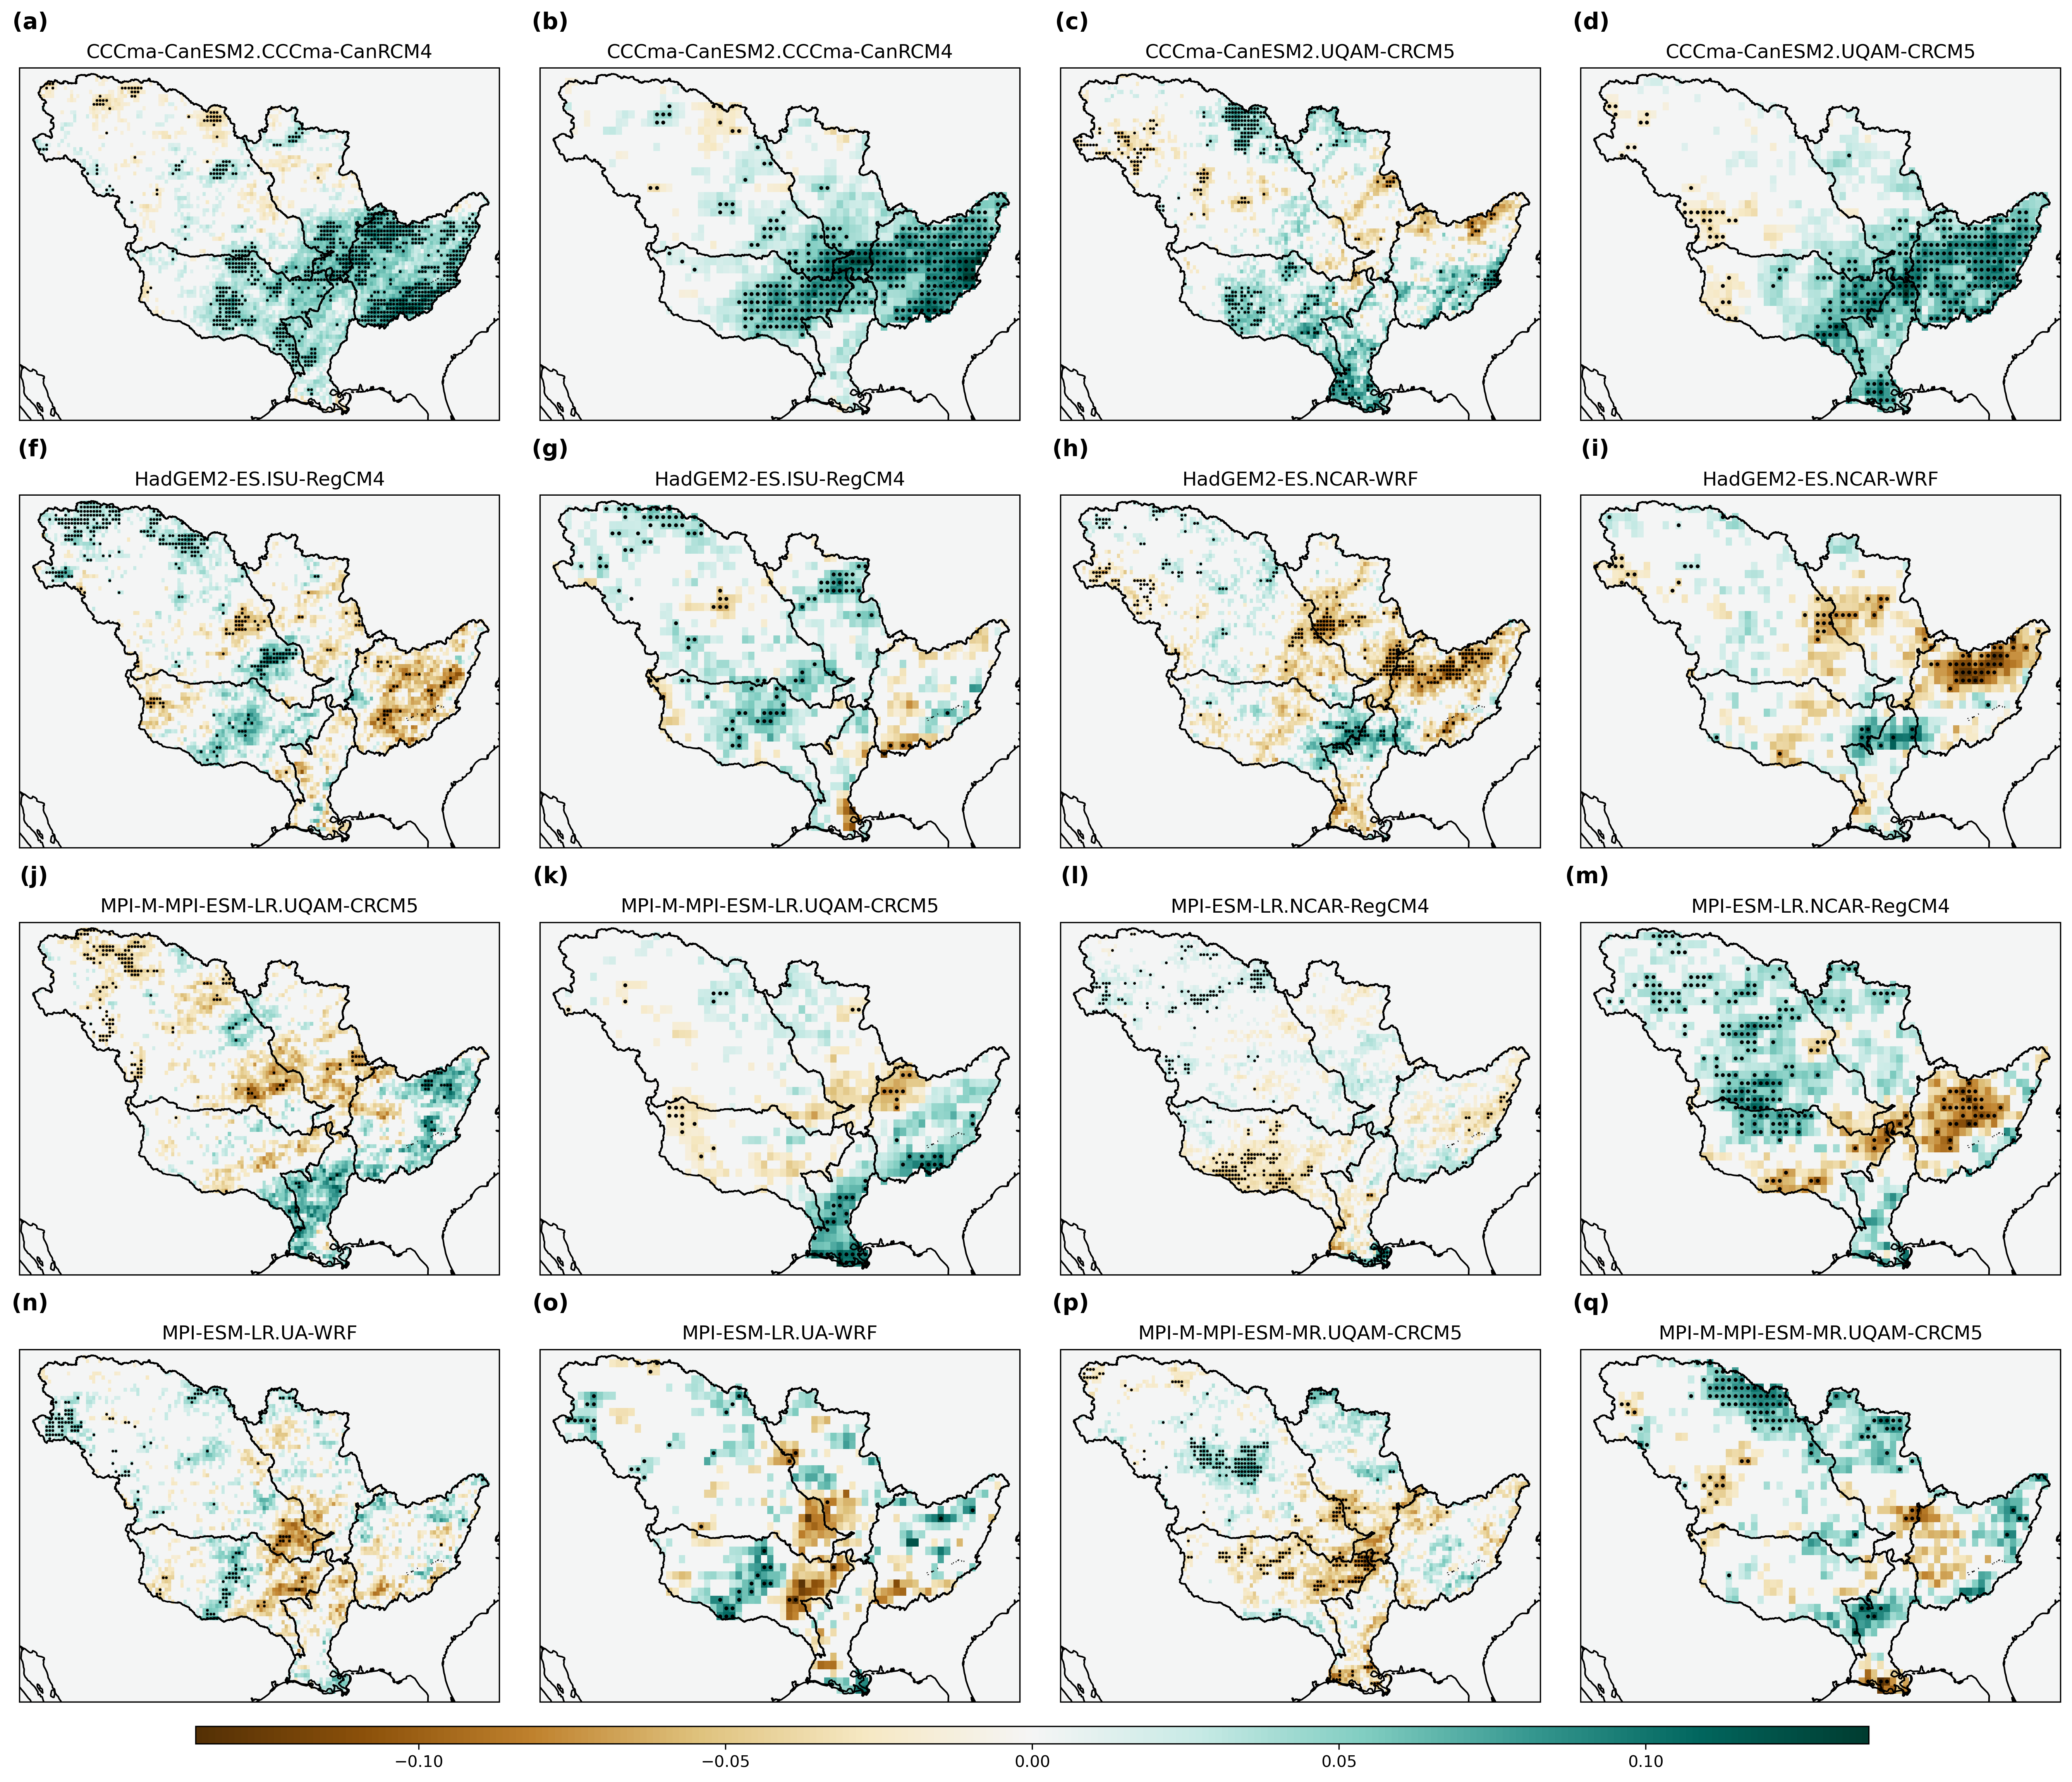

In [83]:
projection = ccrs.PlateCarree()
cmap = cm.get_cmap('BrBG')

fig,axes = plt.subplots(nrows=4,ncols=4,
                       subplot_kw={'projection':projection},
                       figsize=(18,15),dpi=300)

skips = 0
for i in range(17):
    ax = axes[(i-skips)//4,(i-skips)%4]
    if keys[i] == 'CNRM-CM5.CRCM5-OUR.22i':
        skips+=1
        continue
    sig_mask = results[i]['h']
    lats,lons = xr.broadcast(sig_mask['lat'],sig_mask['lon'])
    true_lats,true_lons = lats.where(sig_mask).values,lons.where(sig_mask).values
    sig_pts = ~np.isnan(true_lats)

    ax.set_extent(extent,crs=projection)
    ax.text(0.06, 1.16, f'({chr(97 + i)})', transform=ax.transAxes, fontsize=14,fontweight='bold', va='top', ha='right')
    ax.coastlines()
    
    p = results[i]['slope'].plot(ax=ax,cmap=cmap,transform=projection,add_colorbar=False)
    dsize = 0.5 if (i+skips)%2 == 0 else 2
    ax.scatter(true_lons[sig_pts],true_lats[sig_pts],s=dsize,color='black',transform=projection)
    gdf.plot(ax=ax,facecolor='none')
    ax.set_title(NA_CORDEX[keys[i]].driving_model_id + '.'+ NA_CORDEX[keys[i]].model_id)

cax = fig.add_axes([0.1, 0.0, 0.8, 0.01])
fig.colorbar(p, cax=cax, orientation='horizontal')

plt.tight_layout()
plt.savefig('Mann_Kendall_NA_CORDEX.png',bbox_inches='tight')
plt.show()

**ENSEMBLE MEAN:**<br>
NOTE: in this instance, 'ensemble mean' referes to the *mean of the slopes* not the *slope of the mean*. The means are grouped by resolution (22i vs. 44i)

In [114]:
_22i,_44i = [],[]
for i,k in enumerate(keys):
    if k == 'CNRM-CM5.CRCM5-OUR.22i':
        continue
    elif k.find('22') == -1:
        _44i.append(results[i]['slope'])
        continue
    _22i.append(results[i]['slope'])

slopeMean_22i = xr.concat(_22i,dim='member').mean(dim='member')
slopeMean_44i = xr.concat(_44i,dim='member').mean(dim='member')

In [164]:
# sorts the results by resolution, omitting CNRM-CM5.CRCM5-OUR.22i
r_22i,r_44i = [],[]
for i,k in enumerate(keys):
    if k == 'CNRM-CM5.CRCM5-OUR.22i':
        continue
    elif k.find('22') == -1:
        r_44i.append(results[i])
        continue
    r_22i.append(results[i])
r_res,k_res = [r_22i,r_44i],['22i','44i']

In [169]:
# DESCRIPTION: creates a dictionary (sorted by resolution) of the ensemble results for var (e.g. var='slope' will 
#              package all of the slopes of the 22i models into one ensemble DataArray with the dimension 'member' and 
#              do the same for the 44i models. The ensemble of slopes can then be accessed using the key '22i' or '44i')
ensemble_result = lambda var : {k:xr.concat([j[var] for j in r],dim='member') for k,r in zip(k_res,r_res)}

In [171]:
slope_ensemble = ensemble_result('slope')
h_ensemble = ensemble_result('h')

In [178]:
slope_mean = {k:v.mean(dim='member') for k,v in slope_ensemble.items()} # computes the ensemble mean of the slopes

ensemble_counts = {k:v.sum(dim='member') for k,v in h_ensemble.items()} # counts the number of sig pts across ensemble by gridcell
ensemble_mask = {k: v >= 4 for k,v in ensemble_counts.items()} # mask for pts agreed to be significant by >50% of the models

In [ ]:
%%time
{k:v.max().compute().item() for k,v in ensemble_counts.items()}

<xarray.DataArray 'h' (lat: 86, lon: 152)> Size: 52kB
dask.array<sum-aggregate, shape=(86, 152), dtype=int32, chunksize=(86, 152), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 688B 28.62 28.88 29.12 29.38 ... 49.38 49.62 49.88
  * lon       (lon) float64 1kB -114.9 -114.6 -114.4 ... -77.62 -77.38 -77.12
    region    int64 8B 0
    quantile  float64 8B 0.95
<xarray.DataArray 'h' (lat: 43, lon: 76)> Size: 13kB
dask.array<sum-aggregate, shape=(43, 76), dtype=int32, chunksize=(43, 76), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 344B 28.75 29.25 29.75 30.25 ... 48.75 49.25 49.75
  * lon       (lon) float64 608B -114.8 -114.2 -113.8 ... -78.25 -77.75 -77.25
    region    int64 8B 0
    quantile  float64 8B 0.95
Wall time: 59.8 ms


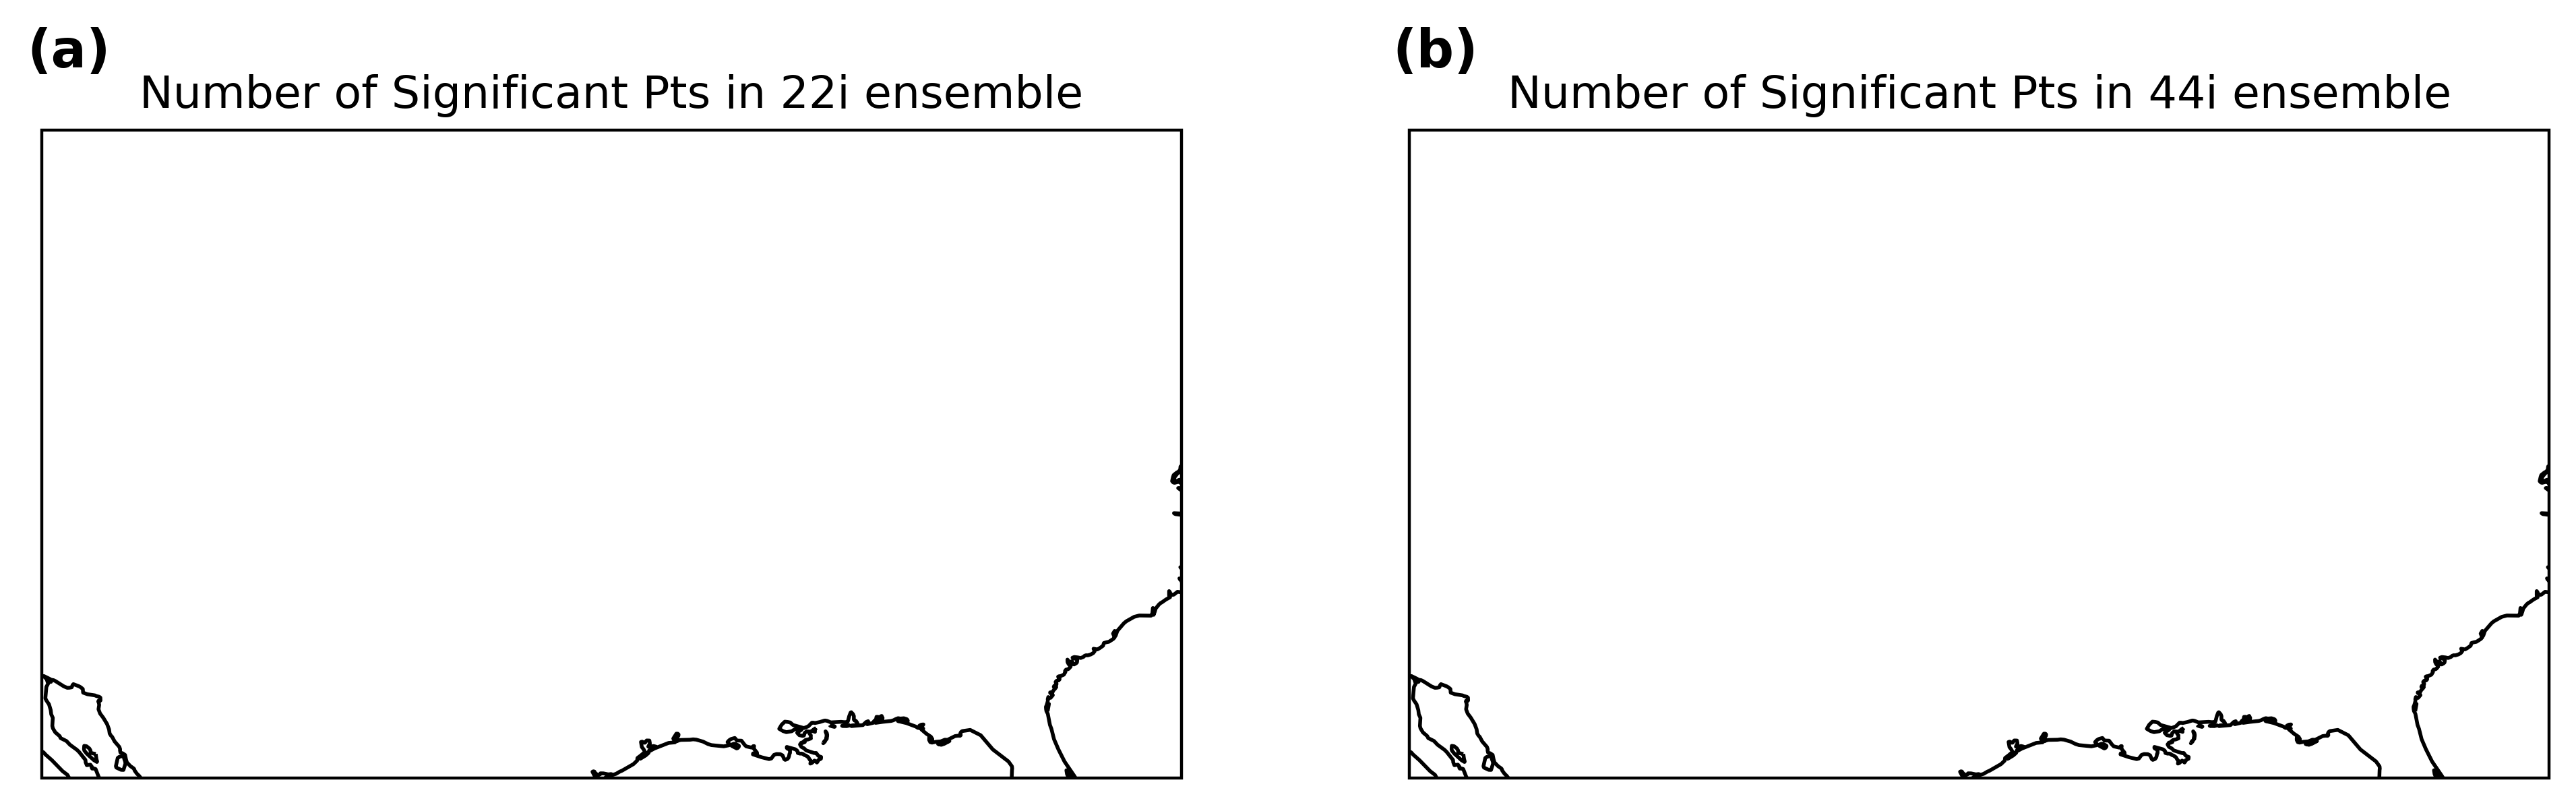

In [183]:
%%time
fig, axes = plt.subplots(nrows=1,ncols=2,
                         subplot_kw={'projection':projection},
                         figsize=(12,6),dpi=400)

for i,ax in enumerate(axes.flatten()):
    ensemble_counts[k_res[i]].plot(ax=ax,cmap='Greens',transform=projection

    # formatting
    ax.set_extent(extent,crs=projection)
    ax.text(0.06, 1.16, f'({chr(97 + i)})', transform=ax.transAxes, fontsize=14,fontweight='bold', va='top', ha='right')
    ax.coastlines()
    ax.set_title('Number of Significant Pts in '+k_res[i]+' ensemble')